# Spectral analysis with Gammapy

## Introduction

This notebook explains how to use the functions and classes in [gammapy.spectrum](http://docs.gammapy.org/en/latest/spectrum/index.html).

Based on a datasets of 4 Crab observations with H.E.S.S. (simulated events for now) we will perform a full region based spectral analysis, i.e. extracting source and background counts from certain 
regions, and fitting them using the forward-folding approach.

Data handling:

* [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html)
* [gammapy.data.DataStoreObservation](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStoreObservation.html)
* [gammapy.data.Target](http://docs.gammapy.org/en/latest/api/gammapy.data.Target.html)
* [gammapy.data.ObservationStats](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationStats.html)
* [gammapy.data.ObservationSummary](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationSummary.html)

To extract the 1-dim spectral information:

* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumExtraction](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumExtraction.html)
* [gammapy.background.ReflectedRegionsBackgroundEstimator](http://docs.gammapy.org/en/latest/api/gammapy.background.ReflectedRegionsBackgroundEstimator.html)


For the global fit (using Sherpa and WSTAT in the background):

* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.spectrum.models.PowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.PowerLaw.html)
* [gammapy.spectrum.models.ExponentialCutoffPowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.ExponentialCutoffPowerLaw.html)
* [gammapy.spectrum.models.LogParabola](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.LogParabola.html)

To compute flux points (a.k.a. "SED" = "spectral energy distribution")

* [gammapy.spectrum.SpectrumResult](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumResult.html)
* [gammapy.spectrum.FluxPoints](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.FluxPoints.html)
* [gammapy.spectrum.SpectrumEnergyGroupMaker](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumEnergyGroupMaker.html)
* [gammapy.spectrum.FluxPointEstimator](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.FluxPointEstimator.html)

We know this is a lot of classes and complexity.
The reason is that we have created Gammapy as a flexible, modular toolbox to implement such analyses.

We will add more high-level classes and command line tools that execute the common workflows like the one done here by hand as a pipeline and output a nice summary, to make the common cases easy.

Feedback welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# Check package versions

import numpy as np
import astropy
import regions
import sherpa

print('numpy:', np.__version__)
print('astropy', astropy.__version__)
print('regions', regions.__version__)
print('sherpa', sherpa.__version__)

('numpy:', '1.11.2')
('astropy', u'1.3')
('regions', u'0.3.dev410')
('sherpa', 'ciao4.9+1.g1ebebb7')


In [3]:
import logging

# units and coordinates from astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

# Regions 
from regions import CircleSkyRegion

# Datastore is the interface to the index of observations 
from gammapy.data import Target
from gammapy.data import DataStore, ObservationList
from gammapy.data import ObservationStats, ObservationSummary

# The background method
from gammapy.background.reflected import ReflectedRegionsBackgroundEstimator

# Some utility function to deal with energy axis (log binning with a unit etc)
from gammapy.utils.energy import EnergyBounds

# The class performing the extraction and extraction results
from gammapy.spectrum import SpectrumExtraction, SpectrumObservation, SpectrumFit, SpectrumResult

# Spectral models
from gammapy.spectrum.models import PowerLaw, ExponentialCutoffPowerLaw, LogParabola
# Utilities for flux points plotting
from gammapy.spectrum import FluxPoints, SpectrumEnergyGroupMaker, FluxPointEstimator

# A class to deal with exclusion regions
from gammapy.image import SkyMask

from gammapy.extern.pathlib import Path


In [4]:
# Setup the logger
logging.basicConfig()
#print(logging.Logger.manager.loggerDict)
log = logging.getLogger('gammapy.spectrum')

# Debug
#log.setLevel(10)
# Not set
log.setLevel(0)

## Load Data

First, we select and load some H.E.S.S. observations of the Crab nebula (simulated events for now).

We will access the events, effective area, energy dispersion, livetime and PSF for containement correction.

In [5]:
DATA_DIR = '$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2'

datastore = DataStore.from_dir(DATA_DIR)
obs_ids = [23523, 23526, 23559, 23592]

observations = ObservationList(datastore.obs(obs_id) for obs_id in obs_ids)
print(observations[0])

Info for OBS_ID = 23523
- Start time: 53343.92
- Pointing pos: RA 83.63 deg / Dec 21.51 deg
- Observation duration: 1687.0 s
- Dead-time fraction: 6.240 %



## Define Target Region

The next step is to define a signal extraction region, also known as on region. In the simplest case this is just a [CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html#regions.CircleSkyRegion), but here we will use the ``Target`` class in gammapy that is useful for book-keeping if you run several analysis in a script.

In [6]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit='deg', frame='icrs')
on_region_radius = Angle('0.11 deg')
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

target = Target(on_region=on_region, name='Crab', tag='crab_example')
# print(target)

## Load exclusion mask

Most analysis will require a mask to exclude regions with possible gamma-ray signal from the background estimation procedure. For simplicity, we will use a pre-cooked exclusion mask from gammapy-extra which includes (or rather excludes) all source listed in the [TeVCat](http://tevcat.uchicago.edu/) and cutout only the region around the crab.

TODO: Change to [gamma-cat](https://gammapy.github.io/gamma-cat/)

In [7]:
EXCLUSION_FILE = '$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits'

allsky_mask = SkyMask.read(EXCLUSION_FILE)
exclusion_mask = allsky_mask.cutout(
    position=target.on_region.center,
    size=Angle('6 deg'),
)

## Estimate background

Next we will manually perform a background estimate by placing [reflected regions](http://docs.gammapy.org/en/latest/background/reflected.html) around the pointing position and looking at the source statistics. In a real analysis you probably don't want to this every time. In this case you can also pass the background estimation parameters directly to the ``SpectrumExtraction`` class, as shown below in [Extract Spectrum](#extract_spectrum).

In [8]:
background_estimator = ReflectedRegionsBackgroundEstimator(
    on_region=target.on_region,
    obs_list = observations,
    exclusion = exclusion_mask)

background_estimator.run()
bkg = background_estimator.result

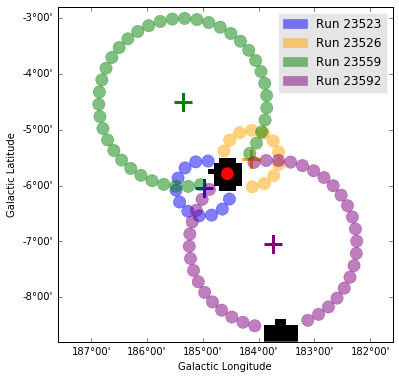

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=exclusion_mask.wcs)
exclusion_mask.plot(fig=fig, ax=ax)

on_patch = on_region.to_pixel(wcs=exclusion_mask.wcs).as_patch(color='red')
ax.add_patch(on_patch)

# without this the axis limits are changed when calling scatter
ax.autoscale(enable=False)

colors = ['blue', 'orange', 'green', 'purple']
handles = list()
for obs_index, obs in enumerate(observations):
    for off in bkg[obs_index].off_region:
        off_patch = off.to_pixel(wcs=exclusion_mask.wcs).as_patch(color=colors[obs_index], alpha=0.5,
                                                                  label='Run {}'.format(obs.obs_id))
        handle = ax.add_patch(off_patch)
    handles.append(handle)
    
    test_pointing = obs.pointing_radec
    ax.scatter(test_pointing.galactic.l, test_pointing.galactic.b,
               transform=ax.get_transform('galactic'),
               marker='+', color=colors[obs_index], s=300, linewidths=3)
    
ax.legend(handles=handles)

## Source statistic

Next we're going to look at the overall source statistics in our signal region. For more info about what debug plots you can create check out the [ObservationSummary](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationSummary.html#gammapy.data.ObservationSummary) class.

*** Observation summary report ***
Observation Id: 23526
Livetime: 0.437 h
On events: 168
Off events: 58
Alpha: 0.091
Bkg events in On region: 5.27
Excess: 162.73
Excess / Background: 30.86
Gamma rate: 6.41 1 / min
Bkg rate: 0.20 1 / min
Sigma: 24.24



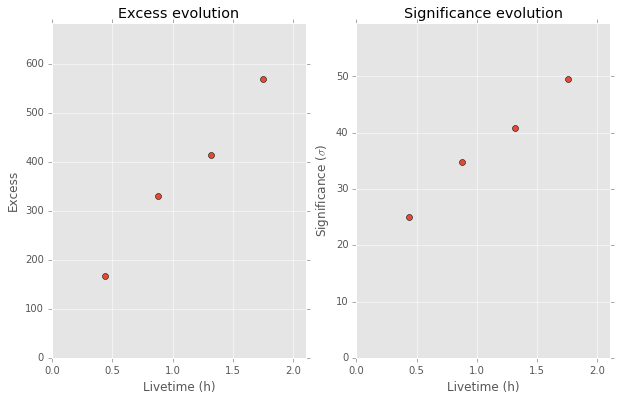

In [10]:
stats = []
for _obs, _bkg in zip(observations, bkg):
    stats.append(ObservationStats.from_target(_obs, target, _bkg))
    
print(stats[1])
obs_summary = ObservationSummary(stats)
fig = plt.figure(figsize=(10,6))
ax1=fig.add_subplot(121)
obs_summary.plot_excess_vs_livetime(ax=ax1)
ax2=fig.add_subplot(122)
obs_summary.plot_significance_vs_livetime(ax=ax2)



## Extract spectrum

<a id='extract_spectrum'></a>

Finally, we're going to extract a spectrum using the [SpectrumExtraction](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumExtraction.html) class. Since most of the time you probably want to go directly to this step, we'll assume you just defined all your input data, but not performed any background estimation. Therefore you have to pass the background estimation parameters as a dict to the ``SpectrumExtraction`` instance. The ``run`` method executes all steps of the extraction process and saves the results in the folder ``ANALYSIS_DIR``.

### Define energy binning

We now provide the reconstructed energy binning we want to use. It is expected to be a Quantity with unit energy, i.e. an array with an energy unit. We use a utility function to create it.

We also provide the true energy binning to use instead of default value.

In [11]:
### Define reco energy binning
e_reco = EnergyBounds.equal_log_spacing(0.1, 40, 40, unit='TeV')

### Define True energy binning
e_true = EnergyBounds.equal_log_spacing(0.05, 100., 200, unit='TeV')

### Perform the spectral extraction

Instantiate a [SpectrumExtraction](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumExtraction.html) object that will do the extraction. This requires a Target object, an ObservationList and a dict containing the method and exclusion mask used for background extraction. 

The containment_correction parameter is there to allow for PSF leakage correction if one is working with full enclosure IRFs.

We also compute a threshold energy and store the result in OGIP compliant files (pha, rmf, arf). This last step might be omitted though.

In [12]:
ANALYSIS_DIR = 'crab_analysis'

bkg_estimation = dict(
    method='reflected',
    exclusion=exclusion_mask,
)

extraction = SpectrumExtraction(target=target,
                                obs=observations,
                                background=bkg_estimation,
                                containment_correction=False
                               )

extraction.estimate_background(extraction.background)
extraction.extract_spectrum()

# Add a condition on correct energy range in case it is not set by default
extraction.define_energy_threshold('area_max', percent=10.0)

# Write output in the form of OGIP files: PHA, ARF, RMF, BKG
#extraction.observations.write(outdir=ANALYSIS_DIR+'/ogip_data/')

# extraction.run(outdir=ANALYSIS_DIR)

/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/astropy-1.3-py2.7-linux-x86_64.egg/astropy/units/quantity.py:951: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/home/kingj/Software/gammapy/gammapy/irf/effective_area.py:255: RuntimeWarning: invalid value encountered in greater
  idx = np.where(self.data.data > aeff)[0][0]


## Look at observations

At this point we could proceed and fit a global model to the spectrum we just extraced. However, we will take a short moment to have a look at the files we just created. We will use the ``SpectrumObservation`` object that are still in memory from the extraction step. Note, however, that you could also read them from disk if you have written them in the step above . The ``ANALYSIS_DIR`` folder contains 4 ``FITS`` files for each observation. These files are described in detail at https://gamma-astro-data-formats.readthedocs.io/en/latest/ogip/index.html. In short they correspond to the on vector, the off vector, the effectie area, and the energy dispersion.

/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


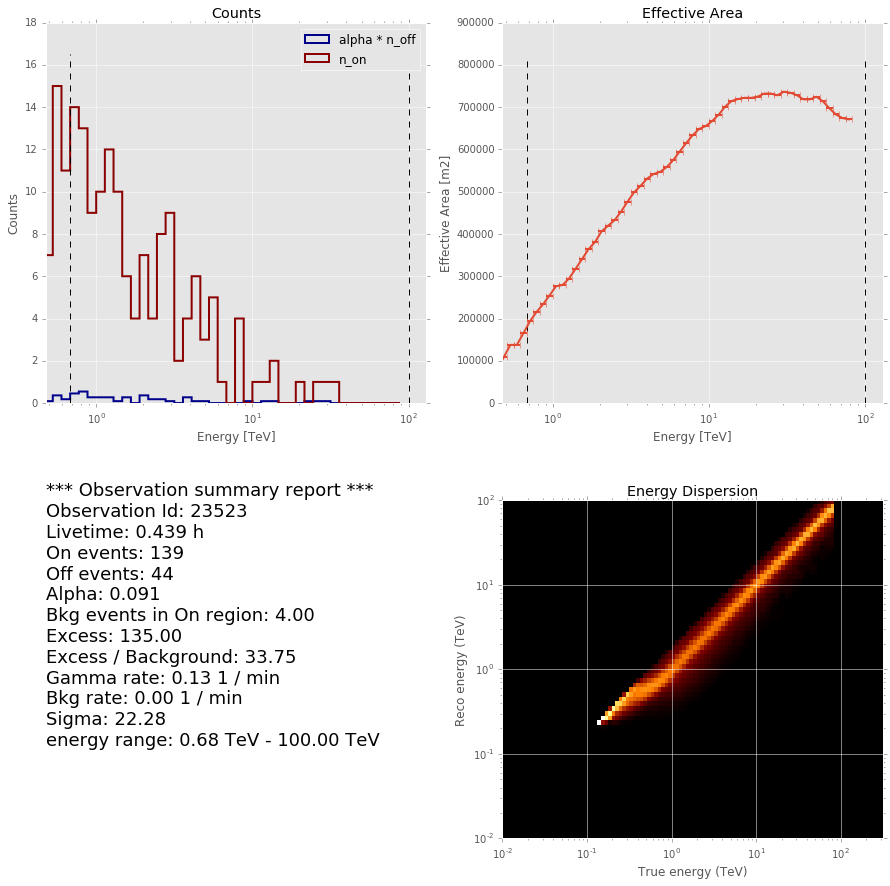

In [13]:
#filename = ANALYSIS_DIR + '/ogip_data/pha_obs23523.fits'
#obs = SpectrumObservation.read(filename)

obs = extraction.observations[0]
obs.peek()

## Fit spectrum

Now we'll fit a global model to the spectrum. First we do a joint likelihood fit to all observations. If you want to stack the observations see below. We will also produce a debug plot in order to show how the global fit matches one of the individual observations.

/home/kingj/Software/gammapy/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/home/kingj/Software/gammapy/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/home/kingj/Software/gammapy/gammapy/stats/fit_statistics.py:198: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/home/kingj/Software/gammapy/gammapy/stats/fit_statistics.py:199: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))



Fit result info 
--------------- 
Model: PowerLaw
ParameterList
Parameter(name=u'index', value=2.1696426627962735, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name=u'amplitude', value=2.0089954999181946e-11, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name=u'reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)

Covariance: [[  2.01273602e-03   2.25932432e-14   0.00000000e+00]
 [  2.25932432e-14   1.04489589e-24   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]] 

Statistic: 34.322 (wstat)
Fit Range: [   0.68129207  100.        ] TeV



(<matplotlib.axes._subplots.AxesSubplot at 0x7ff8ce8891d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff8ce7a25d0>)

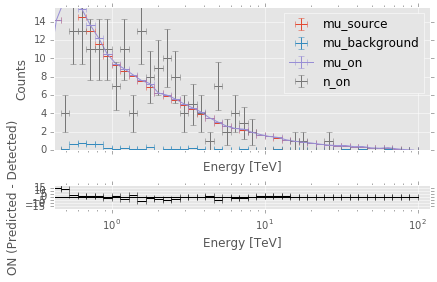

In [14]:
model = PowerLaw(index = 2 * u.Unit(''),
                amplitude = 2e-11 * u.Unit('cm-2 s-1 TeV-1'),
                reference = 1 * u.TeV)

fit = SpectrumFit(extraction.observations, model)

fit.fit()
fit.est_errors()
#fit.run(outdir = ANALYSIS_DIR)

print(fit.result[0])
fit.result[1].plot()

## Compute Flux Points

To round up out analysis we can compute flux points by fitting the norm of the global model in energy bands. We'll use a fixed energy binning for now.

In [15]:
# Define energy binning
ebounds = [0.3, 1.1, 3, 10.1, 30] * u.TeV

stacked_obs = extraction.observations.stack()
seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

print(seg.groups)

SpectrumEnergyGroups:

Info including underflow- and overflow bins:
Number of groups: 6
Bin range: (0, 71)
Energy range: EnergyRange(min=0.01 TeV, max=100.0 TeV)



/home/kingj/Software/gammapy/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  temp = (alpha + 1) / (n_on + n_off)
/home/kingj/Software/gammapy/gammapy/stats/poisson.py:385: RuntimeWarning: divide by zero encountered in log
  m = n_off * log(n_off * temp)
/home/kingj/Software/gammapy/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  l = n_on * log(n_on * temp / alpha)


In [16]:
fpe = FluxPointEstimator(
    obs=obs,
    groups=seg.groups,
    model=fit.model,
)
fpe.compute_points()

    e_max         e_min          e_ref           dnde_err            dnde      
     TeV           TeV            TeV         1 / (m2 s TeV)    1 / (m2 s TeV) 
------------- -------------- -------------- ----------------- -----------------
          1.0 0.681292069058 0.825404185268 4.72957399496e-08 2.73139508336e-07
2.78255940221            1.0   1.6681005372 8.64942194398e-09 6.55764949528e-08
         10.0  2.78255940221   5.2749970637 9.66266411846e-10  5.5248321947e-09
27.8255940221           10.0   16.681005372 1.24378971132e-10 2.78599739036e-10


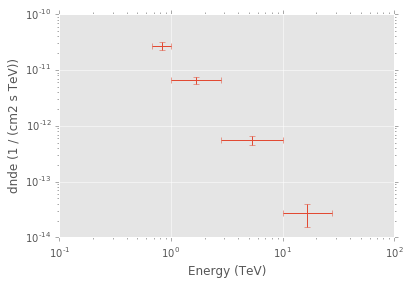

In [17]:
print(fpe.flux_points.table)
# Have to set flux unit here because flux points default unit is ph / ... which raises a unit conversion error
fpe.flux_points.plot(flux_unit = 'cm-2 s-1 TeV-1')

The final plot with the best fit model and the flux points can be quickly made like this

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff8ce6455d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff8cc1590d0>)

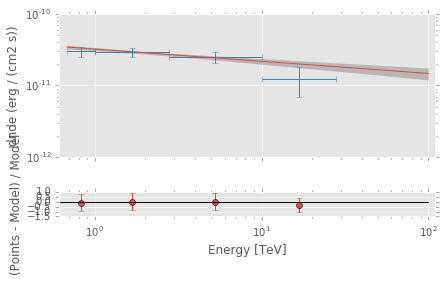

In [18]:
spectrum_result = SpectrumResult(
    points=fpe.flux_points,
    fit=fit.result[0],
)

spectrum_result.plot(
    energy_range=fit.result[0].fit_range,
    energy_power=2, flux_unit='erg-1 cm-2 s-1',
)

## Stack observations

And alternative approach to fitting the spectrum is stacking all observations first and the fitting a model to the stacked observation. This works as follows. A comparison to the joint likelihood fit is also printed.

In [19]:
stacked_obs = extraction.observations.stack()
stacked_fit = SpectrumFit(stacked_obs, model)

stacked_fit.fit()
stacked_fit.est_errors()
print(stacked_fit.result[0])

stacked_table = stacked_fit.result[0].to_table(format='.3g')
stacked_table['method'] = 'stacked'
joint_table = fit.result[0].to_table(format='.3g')
joint_table['method'] = 'joint'
from astropy.table import vstack as vstack_table
print(vstack_table([stacked_table, joint_table])['method', 'index', 'index_err', 'amplitude', 'amplitude_err'])


Fit result info 
--------------- 
Model: PowerLaw
ParameterList
Parameter(name=u'index', value=2.2705300674723246, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name=u'amplitude', value=2.3188025565157718e-11, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name=u'reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)

Covariance: [[  2.64097916e-03   3.99204175e-14   0.00000000e+00]
 [  3.99204175e-14   1.73765755e-24   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]] 

Statistic: 49.483 (wstat)
Fit Range: [   0.68129207  100.        ] TeV

 method index index_err    amplitude     amplitude_err 
                        1 / (cm2 s TeV) 1 / (cm2 s TeV)
------- ----- --------- --------------- ---------------
stacked  2.27    0.0514        2.32e-11        1.32e-12
  joint  2.17    0.0449        2.01e-11        1.02e-12


## Exercises

Some things we might do:

- Fit a different spectral model (ECPL or CPL or ...)
- Use different method or parameters to compute the flux points
- Do a chi^2 fit to the flux points and compare

TODO: give pointers how to do this (and maybe write a notebook with solutions)

In [20]:
# Start the exercises here!

## What next?

In this tutorial we learned how to extract counts spectra from an event list and generate the corresponding IRFs. Then we fitted a model to the observations and also computed flux points.

Here's some suggestions where to go next:

* if you interested in available fit statistics checkout [gammapy.stats](docs.gammapy.org/en/latest/stats/index.html?highlight=gammapy.stats)
* if you want to simulate spectral look at [this tutorial](http://docs.gammapy.org/en/latest/spectrum/simulation.html)
* if you want to compare your spectra to e.g. Fermi spectra published in catalogs have a look at [this](http://docs.gammapy.org/en/latest/spectrum/plotting_fermi_spectra.html)